# Keyword Spotting Model Training

Training a keyword spotting model on a command dataset made by Google.

### Steps:
1. **Setup**
2. **Audio Preprocessing**
3. **Model Definition**
4. **Training**
5. **Evaluation**
6. **Quantization for Deployment**


**1. Setup**

Install and import used libraries.

In [36]:
%%capture
%pip install tensorflow matplotlib scikit-learn tensorflow_datasets

In [37]:
%%capture
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


General constants used in the process

In [38]:
TEST_DATASET_SIZE = 0.1
VALIDATION_DATASET_SIZE = 0.1
EPOCHS = 20

SAMPLE_RATE = 16000
WINDOW_SIZE = 512
STEP_SIZE = 256
LOWER_BAND_LIMIT = 80.0
UPPER_BAND_LIMIT = 7600.0

NUMBER_OF_MEL_BINS = 80
NUMBER_OF_MFCCS = 13


Download the dataset

In [39]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

print("Data directory: ", data_dir)

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Data directory:  data/mini_speech_commands


Print available commands

In [40]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'down' 'yes' 'go' 'stop' 'left' 'up' 'no']


The audio clips are about 1 second long sampled at 16 kHz. The output_sequence_length=16000 pads the short ones to exactly 1 second and trims longer ones so that they can be easily batched.

This function only lets us split the validation dataset from all of the available data. It is later split into test and validation data separately. Because of this, validation_split parameter is set to TEST_DATASET_SIZE + VALIDATION_DATASET_SIZE.

In [41]:
train_dataset, validation_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=TEST_DATASET_SIZE + VALIDATION_DATASET_SIZE,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_dataset.class_names)
print("\nLabel names:", label_names)
print("\nDataset type: ", train_dataset.element_spec)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']

Dataset type:  (TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels). This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis.

In [42]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(squeeze, tf.data.AUTOTUNE)

print("Dataset type: ", train_dataset.element_spec)


Dataset type:  (TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Split validation set into two smaller datasets => one for testing and one for validation.

In [43]:
test_dataset = validation_dataset.shard(num_shards=2, index=0)
validation_dataset = validation_dataset.shard(num_shards=2, index=1)

Check shape of an example audio data

In [44]:
for example_audio, example_labels in train_dataset.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2024-12-09 21:55:24.808019: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Plot a few audio waveforms

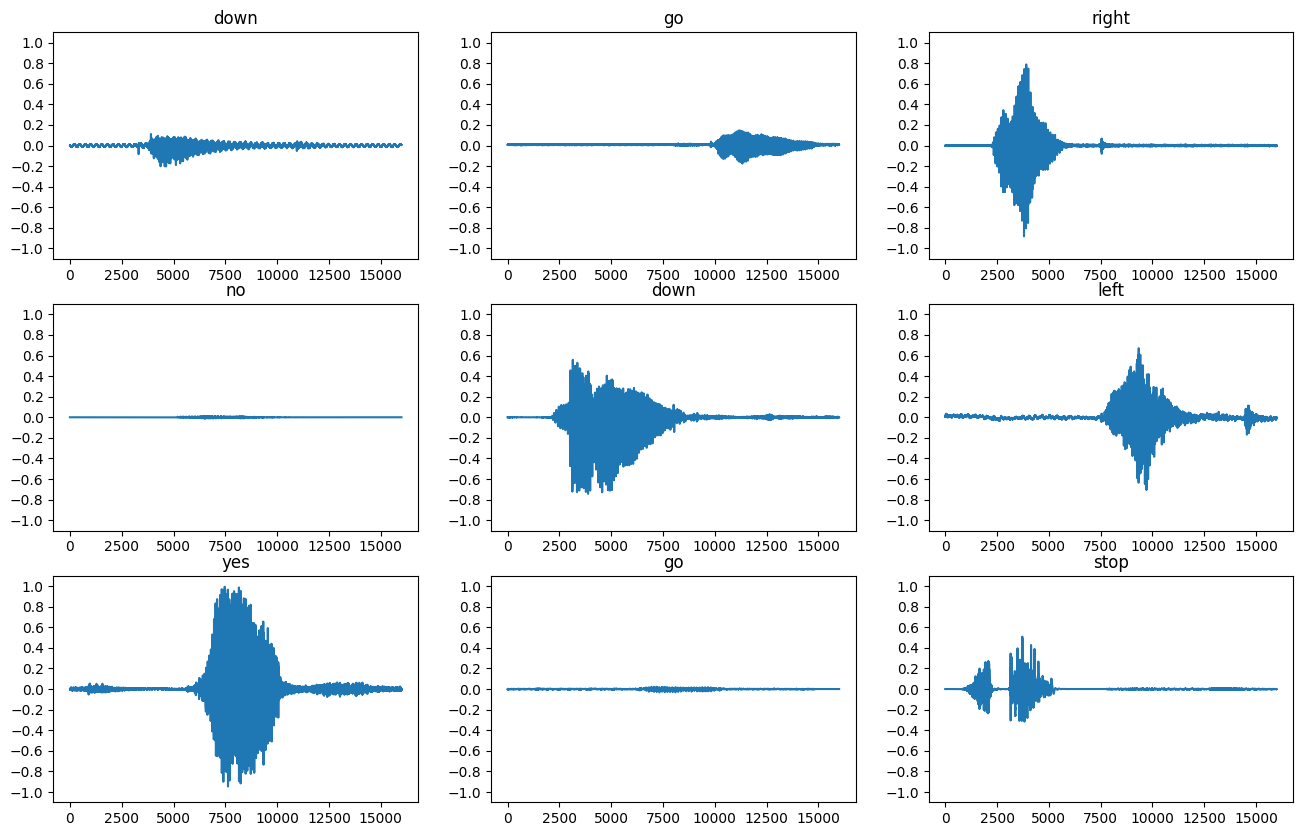

In [45]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

2. **Audio Preprocessing**

Function that generates MFCCs from a given audio sample.

In [46]:
def generate_mfccs(audio):

  # Compute the spectrogram
  stft = tf.signal.stft(
    audio,
    frame_length=WINDOW_SIZE,
    frame_step=STEP_SIZE,
    fft_length=WINDOW_SIZE,
    window_fn=tf.signal.hamming_window
  )

  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(stft)
  #print(spectrogram.shape)

  # Mel filterbank
  num_spectrogram_bins = stft.shape[-1]
  #print("Number of spectogram (frequency) bins:", num_spectrogram_bins)

  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=NUMBER_OF_MEL_BINS,
    num_spectrogram_bins=num_spectrogram_bins,
    sample_rate=SAMPLE_RATE,
    lower_edge_hertz=LOWER_BAND_LIMIT,
    upper_edge_hertz=UPPER_BAND_LIMIT
  )
  #print(linear_to_mel_weight_matrix.shape)

  # Apply the mel filterbank
  mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, axes=1)
  #print(mel_spectrogram.shape)
  mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate([NUMBER_OF_MEL_BINS]))
  #print(mel_spectrogram.shape)

  # Compute log-magnitude mel-spectrograms
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
  #print(log_mel_spectrogram.shape)

  # Compute MFCCs
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
  mfccs = mfccs[..., :NUMBER_OF_MFCCS]  # Take the first N coefficients
  #print("MFCCs shape:", mfccs.shape)

  # Add a `channels` dimension, so that the data can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  return mfccs[..., tf.newaxis]

In [47]:
def plot_mfccs(mfccs, title="MFCCs"):
    """
    Plots MFCCs given a 2D array.

    Args:
        mfccs (np.ndarray or tf.Tensor): 2D array of shape (time, features).
        title (str): Title of the plot.
    """
    if isinstance(mfccs, tf.Tensor):  # Convert Tensor to NumPy array if needed
        mfccs = mfccs.numpy()

    plt.figure(figsize=(10, 6))
    plt.imshow(mfccs.T, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="MFCC Magnitude")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.title(title)
    plt.show()

Generate MFCCs for an example audio

In [48]:
label = label_names[example_labels[6]]
waveform = example_audio[6]
mfccs = generate_mfccs(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('MFCCs shape:', mfccs.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
MFCCs shape: (61, 13, 1)
Audio playback


Plot MFCCs next to a waveform of an example audio data.

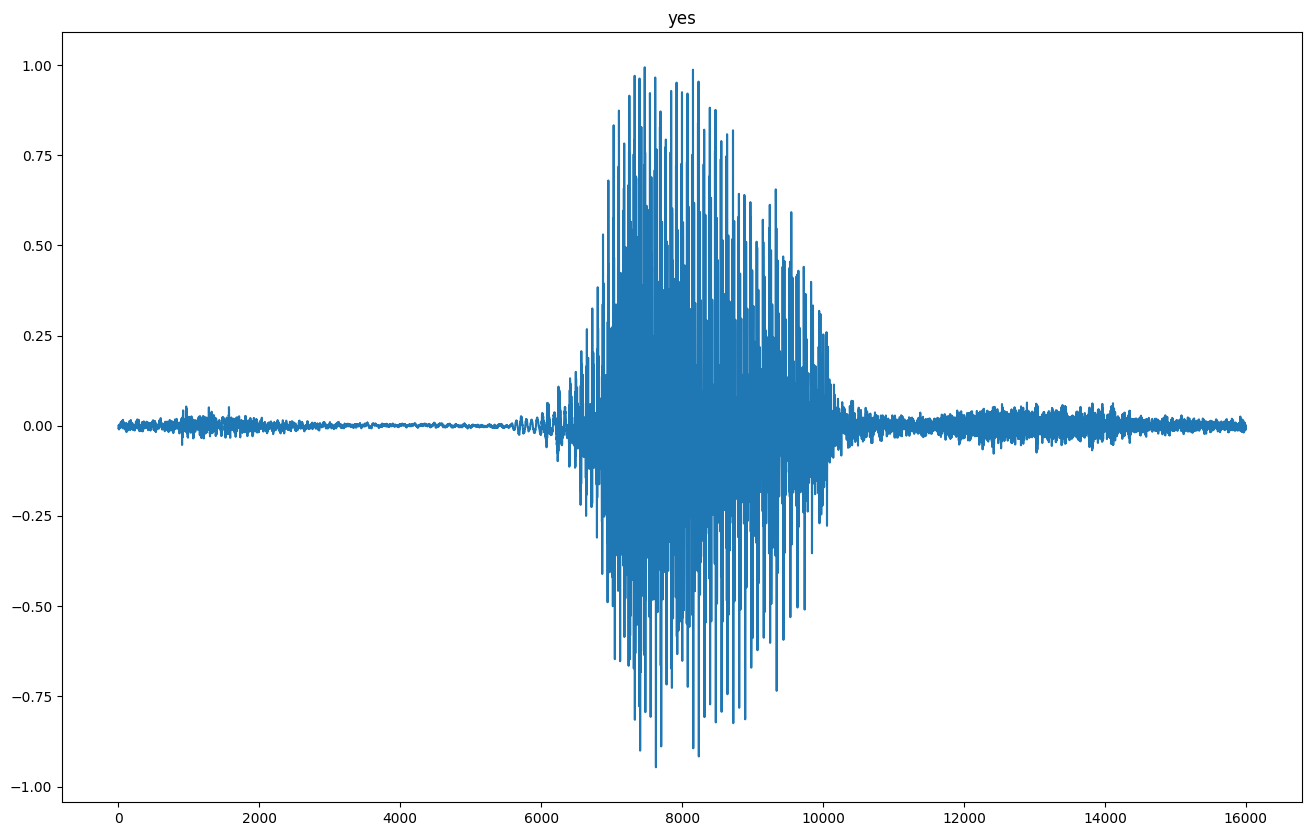

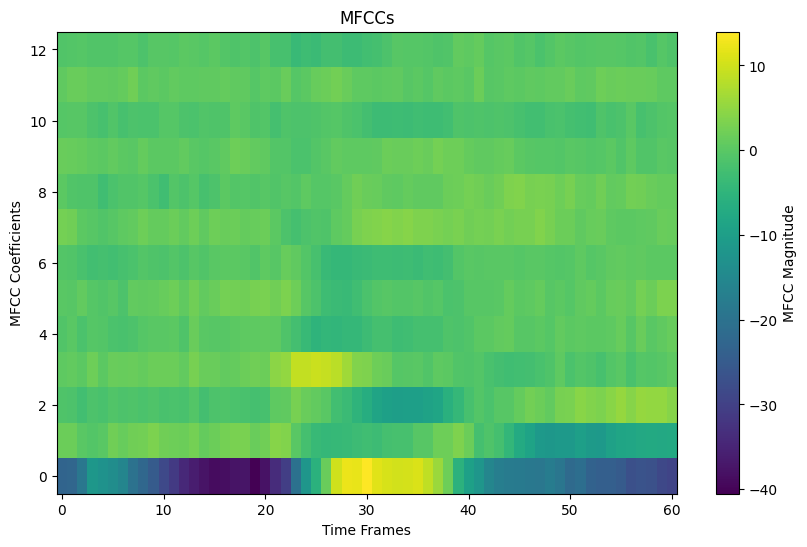

In [49]:
plt.figure(figsize=(16, 10))
plt.plot(waveform)
plt.title(label)
plot_mfccs(tf.squeeze(mfccs, axis=-1))

Create MFCC datasets from waveform datasets

In [50]:
def make_mfcc_dataset(ds):
  return ds.map(
      map_func=lambda audio,label: (generate_mfccs(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [51]:
train_mfcc_dataset = make_mfcc_dataset(train_dataset)
test_mfcc_dataset = make_mfcc_dataset(test_dataset)
validation_mfcc_dataset = make_mfcc_dataset(validation_dataset)

In [52]:
for example_mfcc, example_mfcc_labels in train_mfcc_dataset.take(1):
  break


3. **Model Definition**

Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model

In [53]:
train_mfcc_dataset = train_mfcc_dataset.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_mfcc_dataset = test_mfcc_dataset.cache().prefetch(tf.data.AUTOTUNE)
validation_mfcc_dataset = validation_mfcc_dataset.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into MFCC images.

Your tf.keras.Sequential model will use the following Keras preprocessing layers:

- **tf.keras.layers.Resizing**: to downsample the input to enable the model to train faster.

- **tf.keras.layers.Normalization**: to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [76]:
input_shape = example_mfcc.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print("Number of labels: ", num_labels)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_mfcc_dataset.map(map_func=lambda spec, label: spec))

model = tf.keras.Sequential([
    layers.Input(shape=input_shape),    # Input layer
    #layers.Resizing(32, 32),  # Resize the input to 32x32
    norm_layer,  # Normalize the input
    layers.Conv2D(32, 3, activation='relu'),  # Convolutional Layer 1
    layers.Conv2D(64, 3, activation='relu'),  # Convolutional Layer 2
    layers.MaxPooling2D(),  # Max Pooling Layer
    layers.Dropout(0.25),  # Dropout layer with 25% rate
    layers.Flatten(),  # Flatten the data for dense layers
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout layer with 50% rate
    layers.Dense(num_labels),  # Output layer (no activation, for multi-class classification)
])

model.summary()

Input shape: (61, 13, 1)
Number of labels:  8


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 61, 13, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 59, 11, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 57, 9, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 28, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 937,483 (3.58 MB)

 Trainable params: 937,480 (3.58 MB)

 Non-trainable params: 3 (16.00 B)

In [79]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [80]:
history = model.fit(
    train_mfcc_dataset,
    validation_data=validation_mfcc_dataset,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
  3/100 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.1024 - loss: 2.1107

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy [%]')

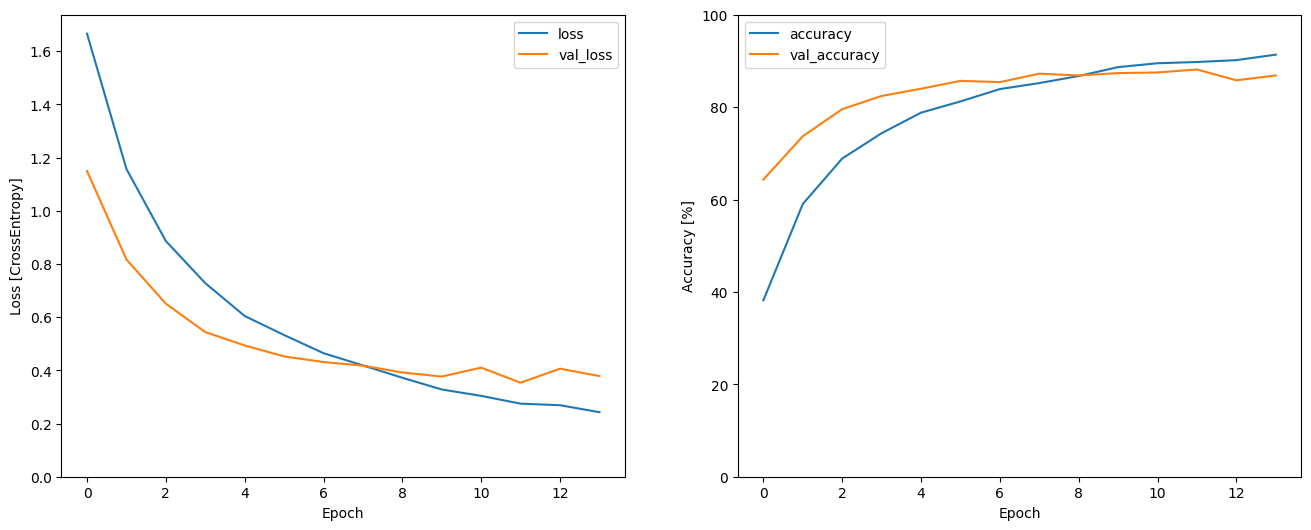

In [81]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [58]:
model.evaluate(test_mfcc_dataset, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8309 - loss: 0.4813


{'accuracy': 0.8497596383094788, 'loss': 0.40524181723594666}

In [59]:
y_pred = model.predict(test_mfcc_dataset)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [60]:
y_pred = tf.argmax(y_pred, axis=1)

In [61]:
y_true = tf.concat(list(test_mfcc_dataset.map(lambda s,lab: lab)), axis=0)

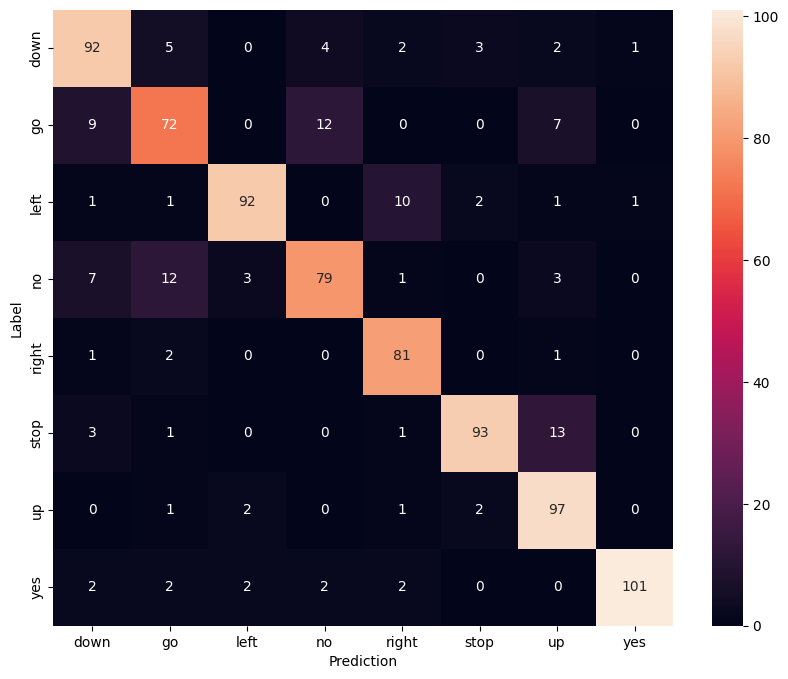

In [62]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

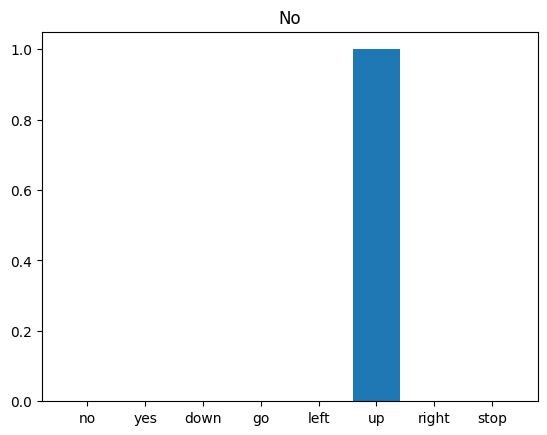

In [70]:
x = data_dir/'stop/0b40aa8e_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = generate_mfccs(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [64]:


class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = generate_mfccs(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [65]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.903724 ,  2.3778448, -3.6579752,  4.5276318, -5.2687707,
         -2.6042209, -2.0886889, -6.062001 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [66]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.903724 ,  2.3778448, -3.6579752,  4.5276318, -5.2687707,
         -2.6042209, -2.0886889, -6.062001 ]], dtype=float32)>}